# MSDS 460 Assignment 4
Monte Carlo simulation


We're going to be looking at a rainfall capture system with some historical rainfall data to see whether our capture system is sufficient to provide the water we want for our home. 

The system has 3k sqft capture system with 90-98% efficiency, a 25k gallon tank, and 4000 to 5200 gallons of monthly water usage.

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
import ipympl
import pandas as pd

# make a ping once everything has finished
from sys import platform
if 'win' in platform:
    import winsound


# also make my axis spacing nice
plt.rcParams.update({'figure.autolayout':True})

In [2]:
# make a fun sound when we finish stuff -- since the MC models take a while to run

def doneTone():
    low_A = 440
    C_sharp = int(440* 2**(4/12))
    E = int(440* 2**(7/12))
    hi_A = int(440* 2)

    winsound.Beep(low_A, 1000)
    winsound.Beep(C_sharp, 1000)
    winsound.Beep(E, 1000)
    winsound.Beep(hi_A, 1000)
    winsound.Beep(E, 1000)
    winsound.Beep(C_sharp, 1000)
    winsound.Beep(low_A, 1500)

### Import historical data
We're interested in monthly rainfall data from 2000-2010. From the assignment -- "Code 'M' as 0"

In [129]:
# bring in the csv
rain_fn = './rainfall-1.csv'
rain_df = pd.read_csv(rain_fn)

# drop the "unnamed" column
rain_df.drop(columns=['Unnamed: 14', 'Year', 'Annual'], inplace=True)
rain_df.drop(index=11, inplace=True) # get rid of 2011

# replace the 'M' with 0
# still need to convert the columns into numeric rather than objects (string)
rain_df = rain_df.replace(to_replace='M', value=0.01).astype(float)

rain_df.describe()

# just so I don't have to type it later on
months = rain_df.columns

Text(0.5, 1.0, 'Historical Monthly Rainfall in San Antonio')

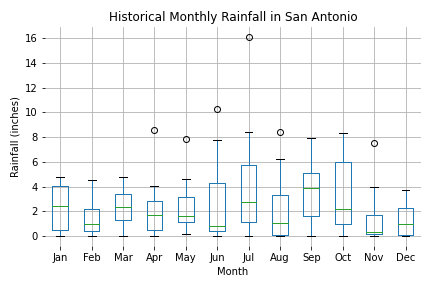

In [4]:
fig,ax = plt.subplots()

rain_df.boxplot(ax=ax)

ax.spines[:].set_visible(False)
ax.set_xlabel('Month')
ax.set_ylabel('Rainfall (inches)')
ax.set_title('Historical Monthly Rainfall in San Antonio')

### Model the rainfall capture and storage system

Set up a system for water coming in, water going out, and keep track of the current water in the tank.

Since we have different amounts of water for each month, we will need to keep track of the month when finding our distribution



In [5]:
# calculate water flow 
class tank():
    def __init__(self, rain_dataframe, tank_size = 25000, capture_size = 3000, usage_range = [4000, 5200], num_months = 360, efficiency=[.9, .98], initial=10000):
        # initialize all of the relevent variables
        self.tank_size = tank_size # how big is our tank (gal)
        self.capt_size = capture_size # how big is our roof system (sqft)
        self.rain_dists = rain_dataframe # historical dataframe
        self.usage_range = usage_range # how much are we using?
        self.num_months = num_months # number of months this is running for (default 30 yrs = 360 months)
        self.eff = efficiency # efficiency range (default 90-98%)

        # dataframe to track historical data
        self.water = pd.DataFrame(columns=['Month','Rainfall', 'Collected', 'Usage','Efficiency','Tank'])

        # set up indices for iteration etc
        self.month_num = 0
        self.tank_level = initial
    
    def rain(self, month):
        return random.choice(self.rain_dists[month])

    def reset(self, initial=10000):
        # set up indices for iteration etc
        self.month_num = 0
        self.tank_level = initial
        # empty the "water" dataframe
        self.water = pd.DataFrame(columns=['Month','Rainfall','Usage','Efficiency','Tank', 'Overflow', 'Underflow'])

    def run_model(self):
        for mnth in np.arange(self.num_months):
            curr_month = self.rain_dists.columns[mnth % 12] # what is the name of the current month?
            rain_ft = self.rain(month=curr_month)/12 # inches to ft
            month_eff = random.random()*(self.eff[1]-self.eff[0]) + self.eff[0] # how efficient is the capture?
            collect = rain_ft * month_eff * self.capt_size * 7.48  # amount we collected this month in gallons
            usage = random.random()*(self.usage_range[1]-self.usage_range[0]) + self.usage_range[0]

            # check if we have overdrawn or overflowed our tank
            underflow = np.nan
            overflow = np.nan
            if usage > (self.tank_level + collect):
                underflow = usage-(self.tank_level + collect) # to see how much we are going over by
                usage = self.tank_level + collect
                self.tank_level = 0 # set tank to empty
            elif (self.tank_level + collect - usage) > self.tank_size:
                overflow = (self.tank_level+collect - usage) - self.tank_size
                collect = (self.tank_size + usage) - self.tank_level
                self.tank_level = self.tank_size
            else:
                self.tank_level = self.tank_level + collect - usage 


            self.water = self.water.append({'Month':curr_month, 'Rainfall':rain_ft, 'Efficiency':month_eff,\
                'Collected':collect, 'Usage':usage, 'Tank':self.tank_level, 'Overflow':overflow, 'Underflow':underflow }, ignore_index=True) 

Run a 30 year simulation, 1000 times

In [56]:
# initialize the class
# our_tank = tank(rain_df) # default
our_tank = tank(rain_df, tank_size=30000, capture_size=6000, initial=25000)

# number of simulations
# n_simul = 1000
n_simul = 100
out_np = np.ndarray([360,7,n_simul])

for sim in np.arange(n_simul):
    our_tank.run_model() # run the model
    out_np[:,0,sim] = our_tank.water['Rainfall']
    out_np[:,1,sim] = our_tank.water['Collected']
    out_np[:,2,sim] = our_tank.water['Usage']
    out_np[:,3,sim] = our_tank.water['Efficiency']
    out_np[:,4,sim] = our_tank.water['Tank']
    out_np[:,5,sim] = our_tank.water['Overflow']
    out_np[:,6,sim] = our_tank.water['Underflow']

    our_tank.reset(initial=25000)

    if (sim%100) == 0:
        print(f"{sim} iterations completed")

print('Done!')
doneTone()

0 iterations completed
Done!


### Plots

We are going to look at the rainfall recorded, the water collected, the tank contents, and the water usage over time


#### Expected tank level, overflow and underflow
We want to look through the tank level over time, and look at how frequently we overflow the tank or don't have enough water to fulfill our needs

Looking at all 1000 traces of the tank level will be a mess. Instead we'll just look at the 5th, 50th, and 95th percentiles for each over time.

Since the majority of time we _won't_ overflow or underflow the tank, we'll only be looking at how frequently we _do_ each. We should probably have some sort of percentages, though.


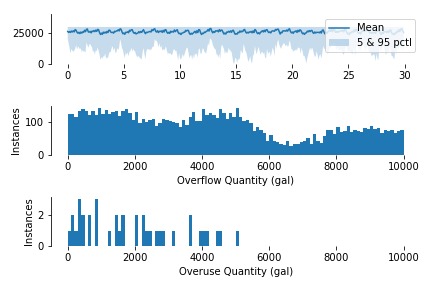

In [57]:
fig, ax = plt.subplots(nrows=3, ncols=1)


# start with the tank level
month_in_years = np.arange(0,30,1/12) # we'll do years on the x-axis, instead of months
tank_quant = np.quantile(out_np[:,4,:], [.01, .5, .95], axis=1).T
# ax[0].plot(month_in_years, tank_quant[:,1], label='Median')
ax[0].plot(month_in_years, out_np[:,4,:].mean(axis=1), label='Mean')
ax[0].fill_between(month_in_years, tank_quant[:,0], tank_quant[:,2], alpha=.25, label='5 & 95 pctl')
# ax[0].plot(tank_quant[:,2], '--', label='95th percentile')
ax[0].set_ylim([-200, 40200])
_ = ax[0].legend()

# next the amount of overflow -- increasing the tank size
ax[1].hist(out_np[:,5].reshape(-1,1), bins=100, range=[0,10000])
ax[1].set_xlabel('Overflow Quantity (gal)')
ax[1].set_ylabel('Instances')
# ax[1].set_title('Overflow instances across all iterations of the model')

# and the underflow -- increasing tank and collection size
ax[2].hist(out_np[:,6].reshape(-1,1), bins=100, range=[0, 10000])
ax[2].set_xlabel('Overuse Quantity (gal)')
ax[2].set_ylabel('Instances')
# ax[2].set_title('Underflow instances across all iterations of the model')

for axs in ax:
    axs.spines[['right','top','bottom']].set_visible(False)


#### Bounding of the Monte Carlo processes.
Let's take a look at the mean values of the rainfall for a few different months, and look at how drawing from the distributions will bound those means.

In [ ]:
fig_rf, ax_rf = plt.subplots(nrows = 4, ncols=3)

# For each month:
for mnth_num in np.arange(12):
    row_num = int(np.floor(mnth_num/3)) # what row are we in?
    col_num = int(mnth_num%3) # what column are we in?
    month = months[mnth_num] # what is the month's name?
    
    month_inds = np.arange(mnth_num,360,12) # every 12 months, starting with whatever month we're currently in

    ax_rf[row_num,col_num].hist(out_np[month_inds,0,:].reshape(-1,1)*12) # from the month in question -- convert from ft to inches
    ax_rf[row_num,col_num].plot(rain_df[month].mean() * np.ones([2,1]), ax_rf[row_num,col_num].get_ylim(), 'k--' )

    ax_rf[row_num,col_num].set_xlabel('Rainfall (inches)')
    ax_rf[row_num,col_num].set_ylabel('Instances')
    ax_rf[row_num,col_num].set_title(month)

    ax_rf[row_num,col_num].spines[['right','top']].set_visible(False)

#### Bootstrapping the mean

An interesting thing to fill out the distribution a little more solidly is to actually take the mean for each run iteration. We will then look at the distribution by way of the histogram. This is similar to doing some sort of kernel estimation, like I saw with Jaques' code he put in the discussions

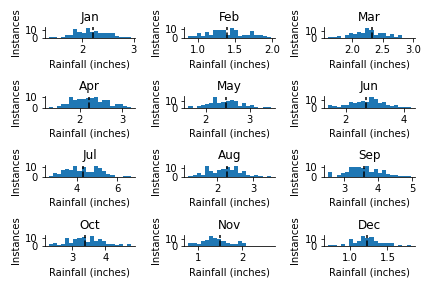

In [131]:
fig_rf, ax_rf = plt.subplots(nrows = 4, ncols=3)

# For each month:
for mnth_num in np.arange(12):
    row_num = int(np.floor(mnth_num/3)) # what row are we in?
    col_num = int(mnth_num%3) # what column are we in?
    month = months[mnth_num] # what is the month's name?
    
    month_inds = np.arange(mnth_num,360,12) # every 12 months, starting with whatever month we're currently in

    ax_rf[row_num,col_num].hist(out_np[month_inds,0,:].mean(axis=0).reshape(-1,1)*12, bins=20) # from the month in question -- convert from ft to inches
    # ax_rf[row_num,col_num].hist(np.quantile(out_np[month_inds,0,:]*12,.5, axis=0), bins=20) # try with the median instead. What that do?
    ax_rf[row_num,col_num].plot(rain_df[month].mean() * np.ones([2,1]), ax_rf[row_num,col_num].get_ylim(), 'k--' )

    ax_rf[row_num,col_num].set_xlabel('Rainfall (inches)')
    ax_rf[row_num,col_num].set_ylabel('Instances')
    ax_rf[row_num,col_num].set_title(month)

    ax_rf[row_num,col_num].spines[['right','top']].set_visible(False)

### Traces of all iterations 

Curious to see what they look like. We'll just plot it with light alphas

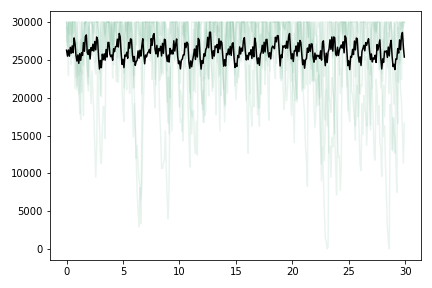

In [127]:
fig_big, ax_big = plt.subplots()

for inst in np.arange(n_simul):
    ax_big.plot(month_in_years, out_np[:,4,inst], color=[.2, .6, .4, .1])

ax_big.plot(month_in_years, out_np[:,4,:].mean(axis=1), 'k')

#### Minimum tank level per run


I suspect this is going to be 0 a lot of the time... 

This might mean that I need to double check my math, since having a histogram of zeros seems a little silly.

(100,)

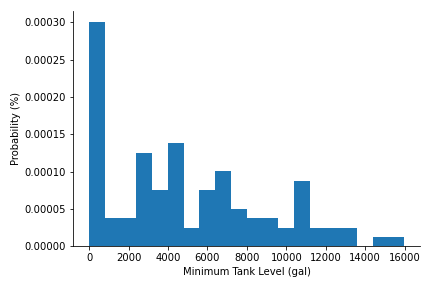

In [58]:
fig_hist,ax_hist = plt.subplots()


ax_hist.hist(out_np[:,4,:].min(axis=0).reshape(-1,1), density=True, bins=20)
ax_hist.set_xlabel('Minimum Tank Level (gal)')
ax_hist.set_ylabel('Probability (%)')

ax_hist.spines[['right','top']].set_visible(False)
# ax_hist.set_xlim([-.1, 60])

out_np[:,4,:].min(axis=0).shape

### Monte Carlo sim to search the space of tank and capture sizes

Let's see what Doc Larry needs to keep in his family's good graces

In [119]:
# going to do a grid search with tank size and capture size

tnk_sz = np.arange(10000,105000,100)
capt_sz = np.arange(1000, 10000, 10)

mins = None


water = pd.DataFrame(columns=['Tank_Size','Capture_Size','Min'])

for iter in range(1000):
    tnk = random.choice(tnk_sz)
    capt= random.choice(capt_sz)
    our_tank = tank(rain_df, tank_size=tnk, capture_size=capt, initial=10000)

    our_tank.run_model()
    water = water.append({'Tank_Size':tnk, 'Capture_Size':capt, 'Min':our_tank.water['Tank'].min()}, ignore_index=True)

    # our_tank.reset(initial=10000)

    if (iter%100) == 0:
        print(f"{iter} iterations completed")

print('Done!')
doneTone()

0 iterations completed
100 iterations completed
200 iterations completed
300 iterations completed
400 iterations completed
500 iterations completed
600 iterations completed
700 iterations completed
800 iterations completed
900 iterations completed
Done!


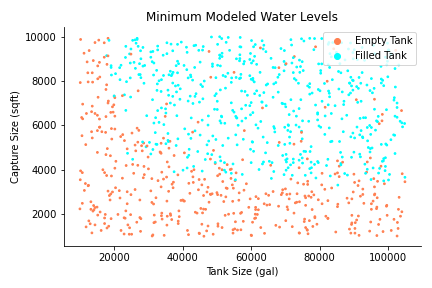

In [125]:
fig_test, ax_test = plt.subplots()

ax_test.scatter(water['Tank_Size'], water['Capture_Size'], s=3, c = water['Min'].eq(0).map({True:'Coral',False:'cyan'}))
ax_test.scatter(None, None, c='coral', label='Empty Tank')
ax_test.scatter(None, None, c='cyan', label='Filled Tank')
ax_test.set_xlabel('Tank Size (gal)')
ax_test.set_ylabel('Capture Size (sqft)')
ax_test.set_title('Minimum Modeled Water Levels')
_ = ax_test.legend()

ax_test.spines[['top','right']].set_visible(False)

In [102]:
np.array(mins[:,2] == 0).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0])